## Importing Library

In [56]:
import numpy as np
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
from IPython.display import Image, display

## Loading dataset

In [57]:
rvar = 1 if np.random.uniform() >0.5 else 0 
data = dowhy.datasets.xy_dataset(10000,
                                 effect = rvar,
                                 sd_error=0.2)
df = data["df"]
df

,Treatment,Outcome,w0,s
0,2.810111,5.774879,-3.137097,6.071074
1,3.960053,8.287142,-1.927836,0.565285
2,10.054513,19.764226,3.825911,2.582761
3,2.080045,4.209468,-3.960323,7.199192
4,9.744210,19.666485,3.946272,3.231793
...,...,...,...,...
9995,3.083721,6.189850,-3.098048,0.335784
9996,9.934292,19.854552,3.985970,3.118447
9997,2.211345,4.478783,-3.733740,6.483996
9998,9.713652,19.391509,3.589190,3.640945


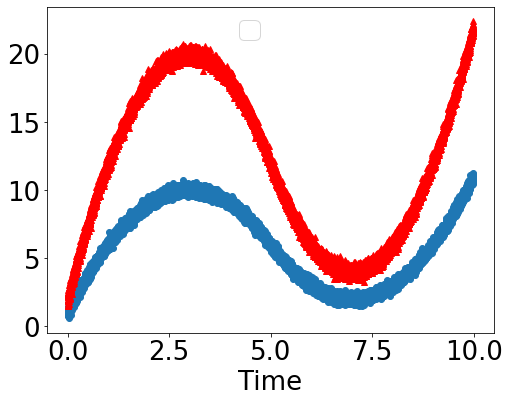

In [58]:
dowhy.plotter.plot_treatment_outcome(df[data["treatment_name"]],
                                     df[data["outcome_name"]],
                                     df[data["time_val"]])

## Modelling

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Treatment'] on outcome ['Outcome']
INFO:dowhy.causal_graph:Using Matplotlib for plotting
C:\Users\Abhishek\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Abhishek\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


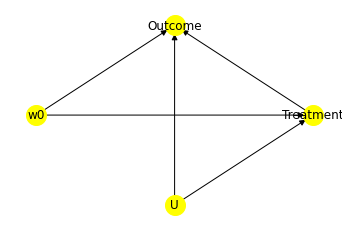

In [62]:
model = CausalModel(data=df,
                   treatment=data["treatment_name"],
                   outcome=data["outcome_name"],
                   common_causes=data["common_causes_names"],
                   instruments=data["instrument_names"])
model.view_model(layout="dot")

In [64]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'w0']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)
### Estimand : 2
Estimand name: iv
No such variable found!



In [65]:
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression")
print("causal estimate is" + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.338e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:25:31   Log-Likelihood:                 2093.6
No. Observations:               10000   AIC:                            -4181.
Df Residuals:                    9997   BIC:                            -4160.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0645      0.059    102.779      0.0

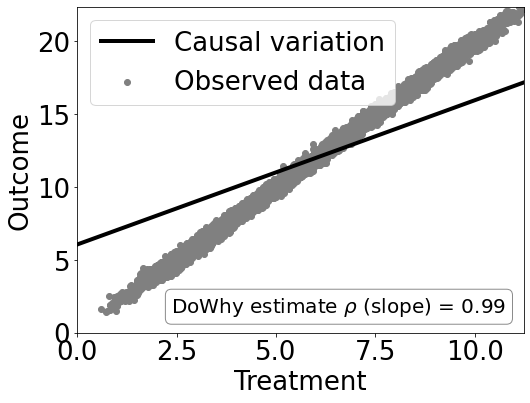

In [68]:
dowhy.plotter.plot_causal_effect(estimate,df[data["treatment_name"]],df[data["outcome_name"]])

## Comparing with the true effect

In [75]:
print("dowhy estimate: "+ str(estimate.value))
print("the real effect: " + str(rvar))

dowhy estimate: 0.9896120389626741
the real effect: 1


# Refuting

1. Random cause

In [77]:
res_random = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0+w_random


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.892e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:47:21   Log-Likelihood:                 2093.6
No. Observations:               10000   AIC:                            -4179.
Df Residuals:                    9996   BIC:                            -4150.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0645      0.059    102.773      0.0

2. Placebo 

In [80]:
res_placebo = model.refute_estimate(identified_estimand , estimate,
                                   method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:26   Log-Likelihood:                -1405.3
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2838.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9945      0.006   1877.418      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:26   Log-Likelihood:                -1405.3
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2838.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9946      0.006   1877.424      0.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.154e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:26   Log-Likelihood:                -1401.1
No. Observations:               10000   AIC:                             2808.
Df Residuals:                    9997   BIC:                             2830.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9830      0.006   1876.397      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:26   Log-Likelihood:                -1405.8
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9984      0.006   1877.962      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:26   Log-Likelihood:                -1405.7
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0049      0.006   1878.886      0.0

INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:27   Log-Likelihood:                -1405.9
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0015      0.006   1878.421      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:27   Log-Likelihood:                -1405.7
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0048      0.006   1878.954      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:27   Log-Likelihood:                -1405.9
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0010      0.006   1878.234      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.153e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:27   Log-Likelihood:                -1403.7
No. Observations:               10000   AIC:                             2813.
Df Residuals:                    9997   BIC:                             2835.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9887      0.006   1876.840      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:28   Log-Likelihood:                -1405.8
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0035      0.006   1878.743      0.0

INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:28   Log-Likelihood:                -1405.9
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0014      0.006   1878.317      0.0

INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:28   Log-Likelihood:                -1405.7
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9973      0.006   1877.638      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:28   Log-Likelihood:                -1405.3
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2838.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0072      0.006   1879.440      0.

INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:28   Log-Likelihood:                -1405.6
No. Observations:               10000   AIC:                             2817.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9966      0.006   1877.575      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:29   Log-Likelihood:                -1405.8
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9983      0.006   1877.942      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:29   Log-Likelihood:                -1405.8
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0032      0.006   1878.681      0.

INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:29   Log-Likelihood:                -1405.9
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0015      0.006   1878.412      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:29   Log-Likelihood:                -1405.8
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0031      0.006   1878.703      0.0

INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:29   Log-Likelihood:                -1405.1
No. Observations:               10000   AIC:                             2816.
Df Residuals:                    9997   BIC:                             2838.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9934      0.006   1877.320      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:30   Log-Likelihood:                -1405.8
No. Observations:               10000   AIC:                             2818.
Df Residuals:                    9997   BIC:                             2839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0030      0.006   1878.484      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.152e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:51:30   Log-Likelihood:                -1405.2
No. Observations:               10000   AIC:                             2816.
Df Residuals:                    9997   BIC:                             2838.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0075      0.006   1879.487      0.0

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Making use of Bootstrap as we have more than 100 examples.
                 Note: The greater the number of examples, the more accurate are the confidence estimates


Refute: Use a Placebo Treatment
Estimated effect:0.9896120389626741
New effect:-3.6431611903608997e-06
p value:0.42000000000000004



3. Removing random subset of data

In [81]:
res_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.9 simulated datasets of size 9000.0 each
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.886e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:07   Log-Likelihood:                 1868.4
No. Observations:                9000   AIC:                            -3731.
Df Residuals:                    8997   BIC:                            -3710.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0704      0.062     97.550      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.892e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:07   Log-Likelihood:                 1865.9
No. Observations:                9000   AIC:                            -3726.
Df Residuals:                    8997   BIC:                            -3704.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0468      0.062     97.346      0.0

INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.898e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:07   Log-Likelihood:                 1876.1
No. Observations:                9000   AIC:                            -3746.
Df Residuals:                    8997   BIC:                            -3725.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0969      0.062     97.937      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.931e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:07   Log-Likelihood:                 1913.4
No. Observations:                9000   AIC:                            -3821.
Df Residuals:                    8997   BIC:                            -3799.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0526      0.062     97.536      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.930e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:07   Log-Likelihood:                 1910.3
No. Observations:                9000   AIC:                            -3815.
Df Residuals:                    8997   BIC:                            -3793.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0486      0.062     97.712      0.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.855e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:08   Log-Likelihood:                 1839.0
No. Observations:                9000   AIC:                            -3672.
Df Residuals:                    8997   BIC:                            -3651.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0679      0.062     97.252      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.891e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:08   Log-Likelihood:                 1862.8
No. Observations:                9000   AIC:                            -3720.
Df Residuals:                    8997   BIC:                            -3698.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0943      0.062     97.863      0.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.862e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:08   Log-Likelihood:                 1818.0
No. Observations:                9000   AIC:                            -3630.
Df Residuals:                    8997   BIC:                            -3609.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0813      0.063     96.741      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.881e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:08   Log-Likelihood:                 1856.3
No. Observations:                9000   AIC:                            -3707.
Df Residuals:                    8997   BIC:                            -3685.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0508      0.062     97.279      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.865e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:09   Log-Likelihood:                 1864.4
No. Observations:                9000   AIC:                            -3723.
Df Residuals:                    8997   BIC:                            -3702.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0685      0.062     97.604      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.902e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:09   Log-Likelihood:                 1875.7
No. Observations:                9000   AIC:                            -3745.
Df Residuals:                    8997   BIC:                            -3724.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0504      0.062     97.021      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.893e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:09   Log-Likelihood:                 1878.8
No. Observations:                9000   AIC:                            -3752.
Df Residuals:                    8997   BIC:                            -3730.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0697      0.062     97.567      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.915e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:09   Log-Likelihood:                 1890.3
No. Observations:                9000   AIC:                            -3775.
Df Residuals:                    8997   BIC:                            -3753.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0395      0.062     97.127      0.

INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.907e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:09   Log-Likelihood:                 1890.6
No. Observations:                9000   AIC:                            -3775.
Df Residuals:                    8997   BIC:                            -3754.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0561      0.062     97.408      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.897e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:10   Log-Likelihood:                 1886.9
No. Observations:                9000   AIC:                            -3768.
Df Residuals:                    8997   BIC:                            -3746.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0451      0.062     97.220      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.904e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:10   Log-Likelihood:                 1878.9
No. Observations:                9000   AIC:                            -3752.
Df Residuals:                    8997   BIC:                            -3731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0497      0.062     97.494      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator



                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.896e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:10   Log-Likelihood:                 1879.1
No. Observations:                9000   AIC:                            -3752.
Df Residuals:                    8997   BIC:                            -3731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0813      0.063     97.242      0.

INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.901e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:10   Log-Likelihood:                 1879.6
No. Observations:                9000   AIC:                            -3753.
Df Residuals:                    8997   BIC:                            -3732.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0348      0.062     96.714      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.903e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:10   Log-Likelihood:                 1869.7
No. Observations:                9000   AIC:                            -3733.
Df Residuals:                    8997   BIC:                            -3712.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0854      0.062     97.567      0.0

INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.933e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:11   Log-Likelihood:                 1906.4
No. Observations:                9000   AIC:                            -3807.
Df Residuals:                    8997   BIC:                            -3785.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0597      0.062     97.572      0.0

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0
INFO:dowhy.causal_refuters.data_subset_refuter:Making use of Bootstrap as we have more than 100 examples.
                 Note: The greater the number of examples, the more accurate are the confidence estimates


                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.891e+06
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:11   Log-Likelihood:                 1864.6
No. Observations:                9000   AIC:                            -3723.
Df Residuals:                    8997   BIC:                            -3702.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0457      0.062     96.974      0.0